<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2">Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1">Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3">Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1">LinearRegression</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-3.2">XGBRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3">CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4">Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1">Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
print(df.index.is_monotonic)

True


In [5]:
df = df.resample('1H').sum()

In [6]:
print('Временной промежуток данных: {} - {}'.format(df.index.min(), df.index.max()))

Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


In [7]:
df_mean = df
df_mean

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


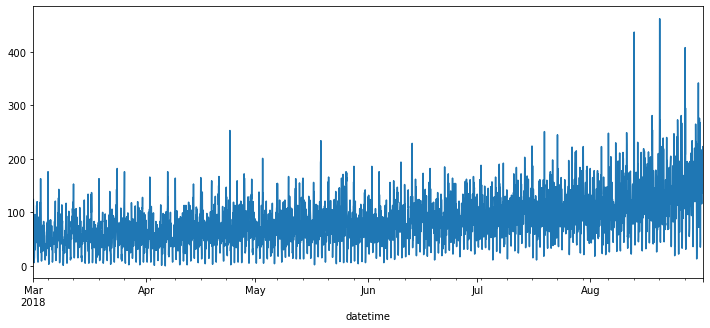

In [8]:
df['num_orders'].plot(figsize=(12,5));

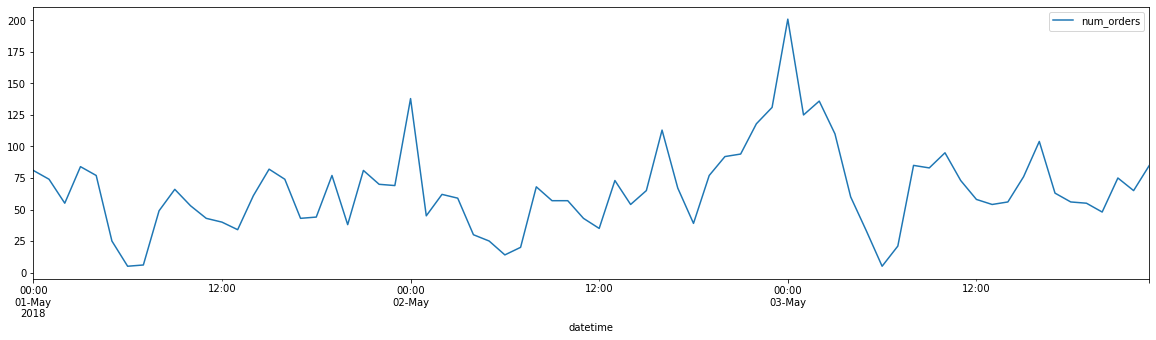

In [9]:
df_1W = df['2018-05-1':'2018-05-3']
df_1W.plot(figsize=(20,5));

В наличии данные за промежуток 2018-03-01 - 2018-08-31.

На всем отрезке времени количество заказов со временем увеличивается.

При близком рассмотрении графика заказов в рамках 3-х дней видны максимумы в 00:00 часов и минимумы в 9:00 часов.

## Анализ

In [10]:
decomposed = seasonal_decompose(df)

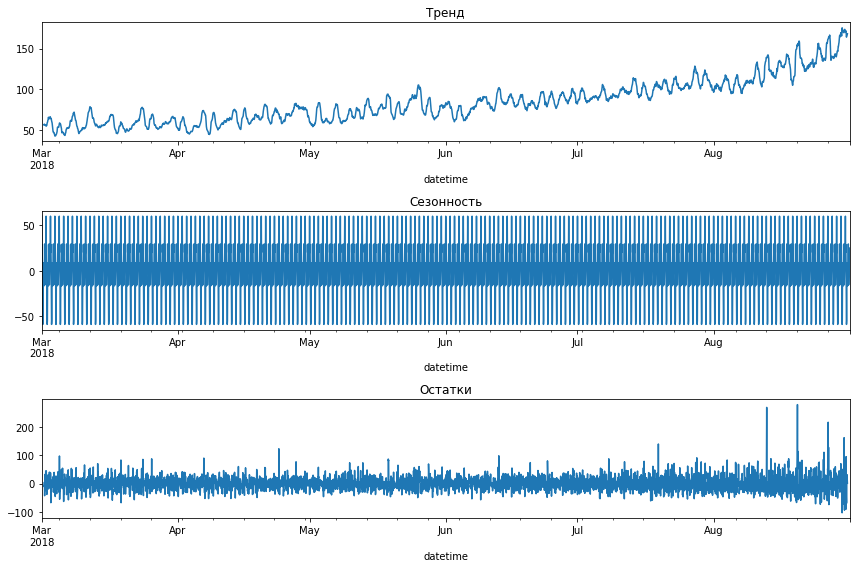

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

На всех данных видно только что современем количество заказов увеличивается.

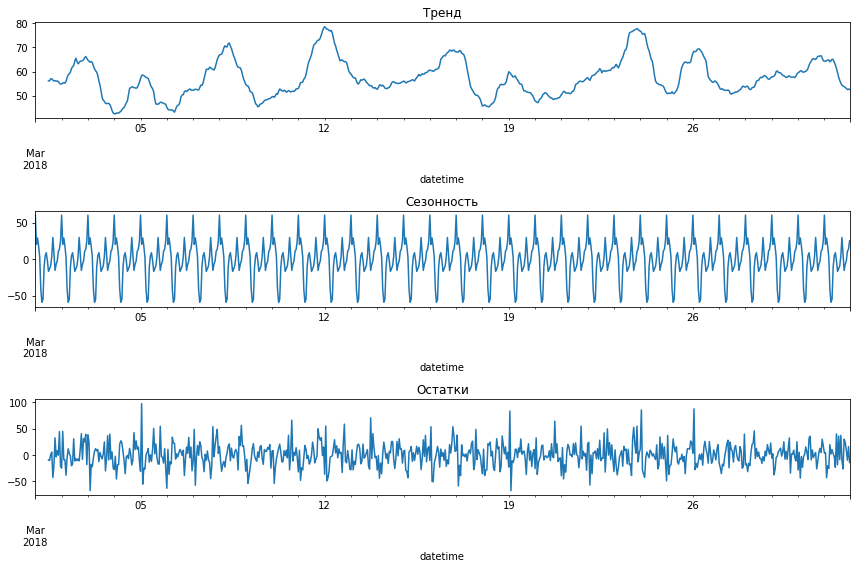

In [12]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend['2018-03'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-03'].plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

На месячных данных видна переодичность увеличения и уменьшения заказов.

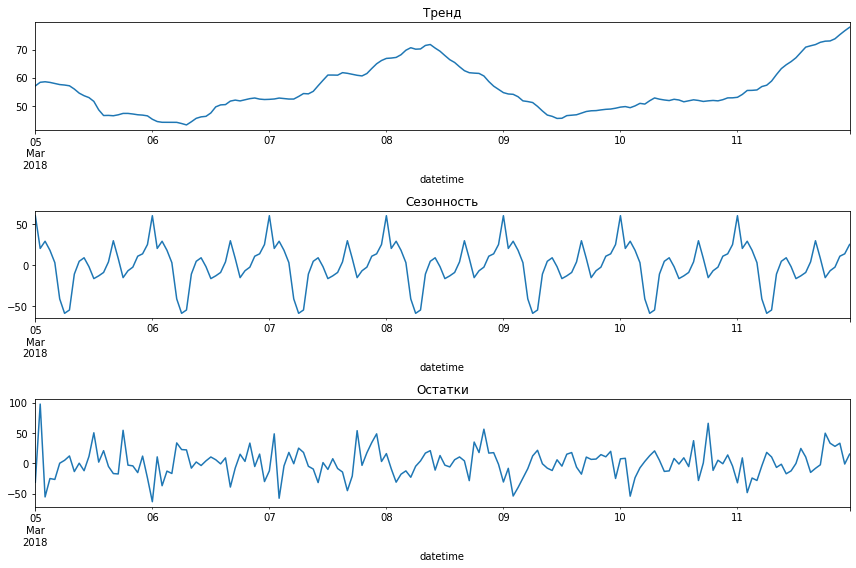

In [13]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend['2018-03-5':'2018-03-11'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-5':'2018-03-11'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-03-5':'2018-03-11'].plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

На недельных данных видно что есть закономерность от времени заказа.

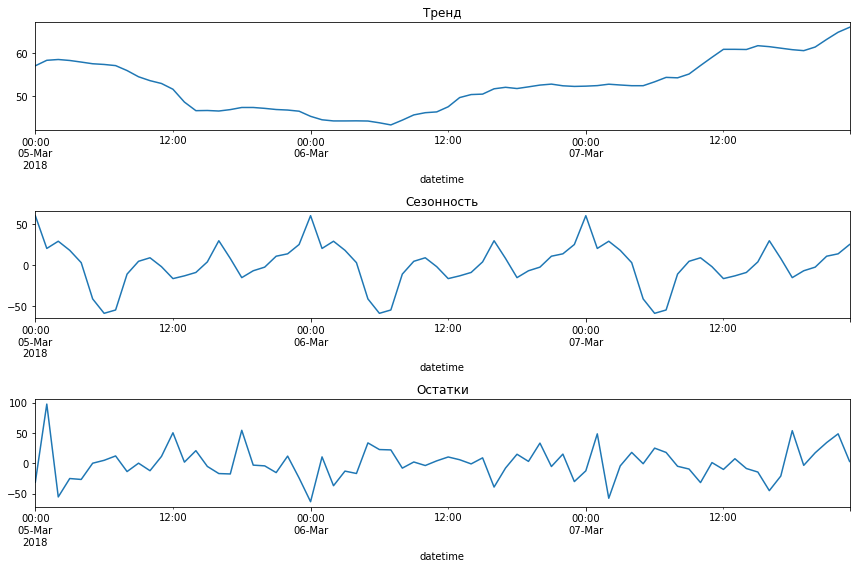

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend['2018-03-5':'2018-03-7'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-5':'2018-03-7'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-03-5':'2018-03-7'].plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

### Вывод
О тренде:
* по тем данным что имеются видно постепенное увеличение спроса на такси.
* На месечном срезе видно что количество заказов от дня к дню переодически увеличивается и уменьшается, скорее всего это связано с рабочими и не рабочими днями.

Сезонность:

* присутствыет сезонность в течении дня, видно что пик приходится на 00:00 часов, а минимум на 06:00 часов.

Остаток:

* средние значения выглядят одинаков на всем отрезке данных.
* Иногда бывают всплески возможно из-за праздников.


## Обучение

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df['difference'] = abs(df['num_orders'] - df['num_orders'].shift())
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for i in range(1, max_lag + 1):
        df['lag_' + str(i)] = df['num_orders'].shift(i)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df['std'] = df['num_orders'].shift().rolling(rolling_mean_size).std()

make_features(df, 10, 10)

In [16]:
df.head()

,num_orders,difference,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,std
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,39.0,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,14.0,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,5.0,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,23.0,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.shape

(4416, 18)

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train, shuffle=False, test_size=0.1)
train = train.dropna()

In [19]:
train.shape, valid.shape, test.shape

((3566, 18), (398, 18), (442, 18))

In [20]:
train_features = train.drop(['num_orders'], axis=1)
valid_features = valid.drop(['num_orders'], axis=1)
test_features = test.drop(['num_orders'], axis=1)

train_target = train['num_orders']
valid_target = valid['num_orders']
test_target = test['num_orders']

In [21]:
#scaler = StandardScaler()
#scaler.fit(train_features)

#train_features = scaler.transform(train_features)
#valid_features = scaler.transform(valid_features)
#test_features = scaler.transform(test_features)

In [22]:
def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict) ** 0.5
    return RMSE

### LinearRegression

In [23]:
LinearReg_model = LinearRegression().fit(train_features, train_target)

predictions = LinearReg_model.predict(valid_features)

print('RMSE на валидационной выборке: ', RMSE(valid_target, predictions).round(2))

RMSE на валидационной выборке:  40.28


### XGBRegressor

In [24]:
param_grid = {'max_depth': [2, 4, 6],
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.3, 0.5]}

In [25]:
%%time
state = 50
a = 0
b = 0
c = 0
for i in param_grid['max_depth']:
    for j in param_grid['n_estimators']:
        for g in param_grid['learning_rate']:
            XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0, random_state=12345, 
                                              shuffle=False, max_depth=i, n_estimators=j, learning_rate=g)
            XGBRegressor_model.fit(train_features, train_target)
            predictions = XGBRegressor_model.predict(valid_features)
            print('max_depth = {} , learning_rate = {}, iterations = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, predictions).round(2)))
            if RMSE(valid_target, predictions).round(2) < state:
                state = RMSE(valid_target, predictions).round(2)
                a = i
                b = j
                c = g
print('Лучшие гиперпараметры:','max_depth = {} , n_estimators = {}, learning_rate = {}, RMSE на валидационной выборке: {}'
                  .format(a, b, c, state))                

max_depth = 2 , learning_rate = 50, iterations = 0.1, RMSE на валидационной выборке: 37.04
max_depth = 2 , learning_rate = 50, iterations = 0.3, RMSE на валидационной выборке: 31.6
max_depth = 2 , learning_rate = 50, iterations = 0.5, RMSE на валидационной выборке: 31.84
max_depth = 2 , learning_rate = 100, iterations = 0.1, RMSE на валидационной выборке: 33.72
max_depth = 2 , learning_rate = 100, iterations = 0.3, RMSE на валидационной выборке: 30.73
max_depth = 2 , learning_rate = 100, iterations = 0.5, RMSE на валидационной выборке: 31.88
max_depth = 2 , learning_rate = 200, iterations = 0.1, RMSE на валидационной выборке: 31.62
max_depth = 2 , learning_rate = 200, iterations = 0.3, RMSE на валидационной выборке: 30.55
max_depth = 2 , learning_rate = 200, iterations = 0.5, RMSE на валидационной выборке: 31.71
max_depth = 4 , learning_rate = 50, iterations = 0.1, RMSE на валидационной выборке: 31.17
max_depth = 4 , learning_rate = 50, iterations = 0.3, RMSE на валидационной выборке: 

In [26]:
XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0, random_state=12345, max_depth = a , 
                                  n_estimators = b, learning_rate = c)

In [27]:
%%time
XGBRegressor_model.fit(train_features, train_target)
predictions = XGBRegressor_model.predict(valid_features)
print('RMSE на валидационной выборке: ', RMSE(valid_target, predictions).round(2))

RMSE на валидационной выборке:  27.12
Wall time: 930 ms


### CatBoostRegressor

In [28]:
CatBoost_model = CatBoostRegressor(random_state=12345)

In [29]:
param_grid = {'max_depth': [2, 4, 6],
              'learning_rate': [0.1, 0.3, 0.5],
              'iterations': [50, 100, 200]}

In [30]:
%%time
state = 50
a = 0
b = 0
c = 0
for i in param_grid['max_depth']:
    for j in param_grid['learning_rate']:
        for g in param_grid['iterations']:
            CatBoost_model = CatBoostRegressor(random_state=12345, max_depth=i, learning_rate=j, iterations=g)
            CatBoost_model.fit(train_features, train_target, verbose=100)
            predictions = CatBoost_model.predict(valid_features)
            print('max_depth = {} , learning_rate = {}, iterations = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, predictions).round(2)))
            if RMSE(valid_target, predictions).round(2) < state:
                state = RMSE(valid_target, predictions).round(2)
                a = i
                b = j
                c = g
print('Лучшие гиперпараметры:','max_depth = {} , learning_rate = {}, iterations = {}, RMSE на валидационной выборке: {}'
                  .format(a, b, c, state))             

0:	learn: 34.9961270	total: 163ms	remaining: 7.99s
49:	learn: 22.7359575	total: 219ms	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 50, RMSE на валидационной выборке: 38.93
0:	learn: 34.9961270	total: 1.31ms	remaining: 129ms
99:	learn: 20.7416775	total: 113ms	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 100, RMSE на валидационной выборке: 34.63
0:	learn: 34.9961270	total: 1.29ms	remaining: 256ms
100:	learn: 20.7195353	total: 113ms	remaining: 111ms
199:	learn: 18.7818839	total: 228ms	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 200, RMSE на валидационной выборке: 32.23
0:	learn: 33.2880580	total: 1.26ms	remaining: 61.9ms
49:	learn: 19.8979920	total: 54.2ms	remaining: 0us
max_depth = 2 , learning_rate = 0.3, iterations = 50, RMSE на валидационной выборке: 33.19
0:	learn: 33.2880580	total: 1.3ms	remaining: 129ms
99:	learn: 17.9676134	total: 108ms	remaining: 0us
max_depth = 2 , learning_rate = 0.3, iterations = 100, RMSE на валидац

In [31]:
CatBoost_model = CatBoostRegressor(random_state=12345, max_depth = a , learning_rate = b, iterations = c)

In [32]:
%%time
CatBoost_model.fit(train_features, train_target, verbose=10)

0:	learn: 32.1028129	total: 29.4ms	remaining: 5.84s
10:	learn: 21.2333276	total: 45.3ms	remaining: 778ms
20:	learn: 19.0415625	total: 62.7ms	remaining: 534ms
30:	learn: 17.4093315	total: 79.3ms	remaining: 433ms
40:	learn: 16.4026166	total: 96ms	remaining: 372ms
50:	learn: 15.8209848	total: 125ms	remaining: 366ms
60:	learn: 15.1826661	total: 141ms	remaining: 322ms
70:	learn: 14.5801018	total: 158ms	remaining: 287ms
80:	learn: 14.1816899	total: 174ms	remaining: 256ms
90:	learn: 13.7997685	total: 191ms	remaining: 229ms
100:	learn: 13.4033319	total: 208ms	remaining: 204ms
110:	learn: 13.1352162	total: 226ms	remaining: 181ms
120:	learn: 12.8935908	total: 243ms	remaining: 159ms
130:	learn: 12.6758959	total: 260ms	remaining: 137ms
140:	learn: 12.4399545	total: 277ms	remaining: 116ms
150:	learn: 12.2175107	total: 303ms	remaining: 98.3ms
160:	learn: 11.9379215	total: 322ms	remaining: 78ms
170:	learn: 11.7567659	total: 340ms	remaining: 57.7ms
180:	learn: 11.5461393	total: 357ms	remaining: 37.4ms

## Тестирование

In [33]:
%%time
predictions = LinearReg_model.predict(test_features)
print('RMSE на тестовой выборке: ', RMSE(test_target, predictions).round(2))

RMSE на тестовой выборке:  54.32
Wall time: 2.88 ms


In [34]:
%%time
predictions = XGBRegressor_model.predict(test_features)
print('RMSE на тестовой выборке: ', RMSE(test_target, predictions).round(2))

RMSE на тестовой выборке:  46.0
Wall time: 4.8 ms


In [35]:
%%time
predictions = CatBoost_model.predict(test_features)
print('RMSE на тестовой выборке: ', RMSE(test_target, predictions).round(2))

RMSE на тестовой выборке:  45.76
Wall time: 5.76 ms


### Вывод

* LinearRegression не прошла по RMSE показав результат 54.32 на тестовой выборке.
* XGBRegressor и CatBoostRegressor показали почти раыние результаты 46.0 и 45.76.
* Лучшей моделью в данной ситуации стала CatBoostRegressor так как она быстрее обучается и предсказывает чем XGBRegressor